# This is for The Classification Task

Training a neural network is an iterative process. In every iteration, we do a pass forward through a model’s layers to compute an output for each training example in a batch of data. Then another pass proceeds backward through the layers, propagating how much each parameter affects the final output by computing a gradient with respect to each parameter. The average gradient for the batch, the parameters, and some per-parameter optimization state is passed to an optimization algorithm, such as Adam, which computes the next iteration’s parameters (which should have slightly better performance on your data) and new per-parameter optimization state. As the training iterates over batches of data, the model evolves to produce increasingly accurate outputs.

Multi Layer Perceptron Classification
In this part, you are required to implement MLP classification from scratch
using numpy, pandas and experiment with various activation functions and
optimization techniques, evaluate the model’s performance, visualize decision
boundaries, and draw comparisons with the previously implemented multino-
mial logistic regression.
2.1 Model Building from Scratch
Build an MLP classifier class with the following specifications: Do not
use sklearn for this.
1. Create a class where you can modify and access the learning rate, activa-
tion function, optimisers, number of hidden layers and neurons.
2. Implement methods for forward propagation, backpropagation, and train-
ing.
3. Different activation functions introduce non-linearity to the model and
affect the learning process. Implement the Sigmoid, Tanh, and ReLU
activation functions and make them easily interchangeable within your
MLP framework.
3
4. Optimization techniques dictate how the neural network updates its weights
during training. Implement methods for the Stochastic Gradient Descent
(SGD), Batch Gradient Descent, and Mini-Batch Gradient Descent algo-
rithms from scratch, ensuring that they can be employed within your MLP
architecture. Additionally, draw comparisons with the inbuilt ADAM op-
timizer in terms of performance.


what is the activation function for output layer

In [197]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from icecream import ic
from sklearn.metrics import confusion_matrix, accuracy_score

In [198]:
DEBUG = False

# Classes For Activation Functions

In [199]:
class Sigmoid: # Sigmoid Function:
    def __init__(self) -> None:
        pass
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    def activation(self, z):
        return self.sigmoid(z)
    def activation_derivative(self, s):
        # s = self.sigmoid(z)
        return s * (1 - s)


class Tanh: # Hyperbolic Tangent (Tanh) Function    
    def __init__(self) -> None:
        pass
    def activation(self, z):
        return np.tanh(z)
    
    def activation_derivative(self, t):
        # t = np.tanh(z)
        return 1 - t**2 

        
class ReLU: # Rectified Linear Unit (ReLU)
    def __init__(self) -> None:
        pass
    def activation(self, z):
        return np.maximum(0, z)
    
    def activation_derivative(self, z):
        return (z > 0)

class Identity:
    def __init__(self):
        pass

    def activation(self, z):
        # Linear activation function (identity function)
        return z

    def activation_derivative(self, z):
        # Derivative of the linear activation function is always 1
        return np.ones_like(z)
    

# Used for Classification
class Softmax:
    def __init__(self) -> None:
        pass
    def activation(self, z):
        # print(z.shape)
        exps = np.exp(z - np.max(z))
        return exps / np.sum(exps, axis=1, keepdims=True)
    
    def activation_derivative(self, z):
        pass

# Classes For Loss Functions

In [200]:
class CrossEntropyLoss:
    def __init__(self, epsilon = 1e-15) -> None:
        self.epsilon = epsilon
    def loss(self, y_pred, y_true):
        epsilon = 1e-10
        loss = -np.sum(y_true * np.log(y_pred+epsilon)) / y_true.shape[0]
        return loss
    def gradient(self, y_pred, y_true):

        return ((y_pred - y_true) / y_true.shape[0])
    
class MSELoss:
    def __init__(self):
        pass

    def loss(self, y_pred, y_true):
        # Calculate the squared differences between predicted and true values
        squared_errors = (y_pred - y_true) ** 2
        # Compute the mean of squared errors
        mse = np.mean(squared_errors)
        return mse

    def gradient(self, y_pred, y_true):
        # Compute the gradient of the MSE loss
        gradient = 2 * (y_pred - y_true) / len(y_true)
        return gradient

# Classes For Layers

$$a^{(1)} = X$$
$$\hat{y} = a^{(L)} = \sigma(z^{(L)})$$
$$a^{(l) = \sigma(z^{(l)})}$$
$$z^{(l)} = W^{(l - 1)}$$
$$\delta^{(L)} = \hat{y} - y$$

### Recurrence Relation for $\delta^{(l)}$

$$\delta^{(l)} = \delta^{(l + 1)}(W^{(l)})^T \odot \sigma'(z^{(l)})$$


$$
   \frac{\partial J}{\partial W^{(l)}} = \frac{1}{m} \delta^{(l + 1)}(a^{(l)})^T
$$

In [201]:
class Layer:
    # no_of_neurons is equal to the no_of_output of the layer
    def __init__(self, no_of_inputs, no_of_neurons, activation) -> None:
        # use xavier initialization
        self.weights = np.random.randn(no_of_inputs, no_of_neurons) * np.sqrt(1 / no_of_inputs)
        self.bias = np.zeros((1, no_of_neurons))
        self.activation = activation
        
    def forward(self, inputs):
        self.inputs = inputs
        # self.inputs represents the activations of the previous layer a^{(l)}    

        
        self.a = self.activation.activation(np.dot(self.inputs, self.weights) + self.bias) 
        self.f_prime_z = self.activation.activation_derivative(self.a)
        return self.a
      
    
    def backward(self, delta, weights):
        # Element-wise multiplication for the derivative of the activation function
        
        # 1/m is already included in the gradient of the loss function
        delta = np.dot(delta, weights.T) * self.f_prime_z
                
        self.dj_dw = np.dot(self.inputs.T, delta)
        self.dj_db = np.sum(delta, axis=0, keepdims=True)
        
        
        return delta
    
    def update_weights(self, learning_rate):
        # Update weights and bias
        self.weights -= learning_rate * self.dj_dw
        self.bias -= learning_rate * self.dj_db
    
class InputLayer:
    def __init__(self, input_size) -> None: # input_size is unnecessary here
        self.f_prime_z = None
        self.weights = None
    def forward(self, inputs):
        # Forward pass for the input layer is just passing the input data
        return inputs

    def backward(self, delta):
        # The input layer has no weights, so the gradient is not modified
        return delta
    def update_weights(self, learning_rate):
        pass

class OutputLayer:
    def __init__(self, no_of_inputs, no_of_neurons, activation) -> None:
        self.weights = np.random.randn(no_of_inputs, no_of_neurons) * np.sqrt(1 / no_of_inputs)
        self.bias = np.zeros((1, no_of_neurons))
        self.f_prime_z = None
        self.activation = activation
        # ic(activation)
        
        # ic(self.weights.shape)
        
        # if no_of_neurons == 1:
        #     self.activation = Identity()
        # else:
        #     self.activation = Softmax()
            
    def forward(self, inputs):
        self.inputs = inputs
        # self.z = np.dot(self.inputs, self.weights)
        # self.a = self.activation.activation(np.dot(self.inputs, self.weights))
        self.a = self.activation.activation(np.dot(self.inputs, self.weights)+self.bias)
        return self.a
    
    def backward(self, delta):
        # grad_output is the gradient of the loss function with respect to the output of the layer
        # The gradient of the loss with respect to the input of the layer
        
        # self.dzdW = inputs.T
        # basically self.inputs.T is the same as self.dzdW
        self.dj_dw = np.dot(self.inputs.T, delta)
        self.dj_db = np.sum(delta, axis=0, keepdims=True)
        
        # grad_weights = np.dot(self.inputs.T, grad_output)
        # grad_bias = np.sum(grad_output, axis=0, keepdims=True)

        # The gradients of the loss with respect to the parameters of the layer
        
        # delta last layer
        return delta
    
    def update_weights(self, learning_rate):
        # Update weights and bias
        self.weights -= learning_rate * self.dj_dw
        self.bias -= learning_rate * self.dj_db
    
    # update will look something like this
    # def update(self, learning_rate):
    #     # Update weights and bias
    #     self.weights -= learning_rate * dj_dw
    #     self.bias -= learning_rate * self.grad_bias

# Classes For Optimizers

In [202]:
# TODO: Add classes for optimizers

In [203]:
class MLP:
    def __init__(self, input_size, hidden_layer_sizes, output_size,\
                 activation_function, output_activation_function, optimizer, loss, learning_rate = 0.001) -> None:
        """
        input_size: number of features in the input
        
        hidden_layer_sizes: list of number of neurons in each hidden layer
        
        output_size: number of classes in the output
        
        activation_function: list of activation function for each layer
        
        learning_rate: learning rate for gradient 
        """
        
        self.act_dict = {
            "sigmoid": Sigmoid(),
            "tanh": Tanh(),
            "relu": ReLU(),
            "identity": Identity(),
            "softmax": Softmax()
        }
        
        
        # # initial plan was to implement classes for the optimizers
        # self.opt_dict = {
        #     "sgd": SGD(),
        #     "bgd": BGD(),
        #     "mbsgd" : MBGD()
        # }
        
                
        for act in activation_function:
            act = act.lower()
            
        self.optimizer = optimizer
        
        self.layers = []
        # self.activation_function = []
        self.learning_rate = learning_rate
        self.loss = loss
        
        self.losses = []
        self.val_losses = []
        
        # self.y_pred = None

        # initialize the input layer
        self.layers.append(InputLayer(input_size))
        
        hidden_layer_sizes.insert(0, input_size)
        # +1 for the ones we are inserting in X
        
        # ic(hidden_layer_sizes)
        
        for i in range(1, len(hidden_layer_sizes)):
            # ic(i)
            self.layers.append(Layer(no_of_inputs=hidden_layer_sizes[i-1],no_of_neurons= hidden_layer_sizes[i], activation=self.act_dict[activation_function[i - 1]]))

        self.layers.append(OutputLayer(hidden_layer_sizes[-1], output_size, self.act_dict[output_activation_function]))
        # print(len(self.layers))
    
    def forward_propagation(self, x)-> None:
        # Forward propagation
        for layer in self.layers:
            x = layer.forward(x)
        return x
        # return Softmax().activation(x)
        # return x
    
    # def backward_propagation(self, x, y)-> None:
    
    def backward_propagation(self, y_pred, y_true)-> None:
        # Forward propagation
        # self.forward_propagation(x)
        
        # calculate the loss gradient with respect to the output of the last layer
        # which is basically dj_dz for the output layer
        # delta_L represents delta for the last layer
        
        delta_L = self.loss.gradient(y_pred, y_true)
        # print(delta_L)
        # grad is dj_dz for the output layer
        # Backpropagation
        delta = delta_L
        # for layer in reversed(self.layers):
        #     delta = layer.backward(delta)
        # do the backword propagation for output layer explicitly and then the hidden layers and then for the input layer
        delta = self.layers[-1].backward(delta)
        # do the backword propagation for hidden layers
        for i in range(len(self.layers) - 2, 0, -1):
            delta = self.layers[i].backward(delta, self.layers[i+1].weights)
        # do the backword propagation for input layer
        delta = self.layers[0].backward(delta)
    
    def predict(self, x):
        # Forward propagation
        return self.forward_propagation(x)
    
    def update_weights(self):
        for layer in self.layers:
            layer.update_weights(self.learning_rate)
        
    
    # Working version of train
    # def train(self, X_train, y_train, X_val, y_val, epochs, batch_size):
    #     self.losses = []
    #     for epoch in range(epochs):
    #         loss = []
    #         for i in range(0, X_train.shape[0], batch_size):
    #             X_batch = X_train[i:i+batch_size]
    #             y_batch = y_train[i:i+batch_size]
    #             y_pred = self.forward_propagation(X_batch)
    #             self.backward_propagation(y_pred=y_pred, y_true=y_batch)
    #             self.update_weights()
    #             # calculate the loss
    #             loss.append(self.loss.loss(y_pred, y_batch))
    #         self.losses.append(np.mean(loss))
    
    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size=None):
        if self.optimizer == "bgd":
            self.train_bgd(X_train, y_train, X_val, y_val, epochs)
        if self.optimizer == "sgd":
            self.train_sgd(X_train, y_train, X_val, y_val, epochs)
        if self.optimizer == "mbgd":            
            self.train_mbgd(X_train, y_train, X_val, y_val, epochs, batch_size)
            
    def train_sgd(self, X_train, y_train, X_val, y_val, epochs):
        self.losses = []
        self.val_losses = []
        for epoch in range(epochs):
            # generate a random index
            for i in range(X_train.shape[0]):
                k = np.random.randint(0, X_train.shape[0])
                X_batch = X_train[k:k+1]
                y_batch = y_train[k:k+1]
                y_pred = self.forward_propagation(X_batch)
                self.backward_propagation(y_pred=y_pred, y_true=y_batch)
                self.update_weights()
            # calculate the loss for the entire training set
            y_pred_train = self.forward_propagation(X_train)
            loss_train = self.loss.loss(y_pred_train, y_train)
            self.losses.append(loss_train)
            
            if X_val is not None and y_val is not None:
                y_pred_val = self.forward_propagation(X_val)
                loss_val = self.loss.loss(y_pred_val, y_val)
                self.val_losses.append(loss_val)
        
            
    def train_bgd(self, X_train, y_train, X_val, y_val, epochs):
        self.losses = []
        self.val_losses = []
        for epoch in range(epochs):
            y_pred = self.forward_propagation(X_train)
            self.backward_propagation(y_pred=y_pred, y_true=y_train)
            self.update_weights()
            # calculate the loss for the entire training set
            y_pred_train = self.forward_propagation(X_train)
            loss_train = self.loss.loss(y_pred_train, y_train)
            self.losses.append(loss_train)
            if X_val is not None and y_val is not None:
                y_pred_val = self.forward_propagation(X_val)
                loss_val = self.loss.loss(y_pred_val, y_val)
                self.val_losses.append(loss_val)
            
    
    def train_mbgd(self, X_train, y_train, X_val, y_val, epochs, batch_size):
        for epoch in range(epochs):
            for i in range(0, X_train.shape[0], batch_size):
                X_batch = X_train[i:i+batch_size]
                y_batch = y_train[i:i+batch_size]
                y_pred = self.forward_propagation(X_batch)
                self.backward_propagation(y_pred=y_pred, y_true=y_batch)
                self.update_weights()
            # calculate the loss for the entire training set
            y_pred_train = self.forward_propagation(X_train)
            loss_train = self.loss.loss(y_pred_train, y_train)
            self.losses.append(loss_train)
            
            if X_val is not None and y_val is not None:
                y_pred_val = self.forward_propagation(X_val)
                loss_val = self.loss.loss(y_pred_val, y_val)
                self.val_losses.append(loss_val)           
            
            


In [204]:
PATH = './dataset/WineQT.csv'
df = pd.read_csv(PATH)
# drop the Id column
df = df.drop('Id', axis=1)
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [205]:
# standardize the data except the target column 'quality'
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df.drop('quality', axis=1))
df_scaled = pd.DataFrame(df_scaled, columns=df.columns[:-1])

quality_min = df['quality'].min()
# print(quality_min)
df_scaled['quality'] = df['quality'].apply(lambda x: x - quality_min)
# df_scaled.head()
# df_scaled.describe()

In [206]:
df_scaled = pd.get_dummies(df_scaled, columns=['quality'])

X = df_scaled.drop(['quality_0', 'quality_1', 'quality_2', 'quality_3', \
                    'quality_4', 'quality_5'], axis=1)\
                        .values

y = df_scaled[['quality_0', 'quality_1', 'quality_2', 'quality_3',\
    'quality_4', 'quality_5']]\
        .values
        
print(X.shape)
print(y.shape)

(1143, 11)
(1143, 6)


In [207]:
# split x into train, test and val set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# For Classification
output_size > 1

loss function -> cross entropy loss function

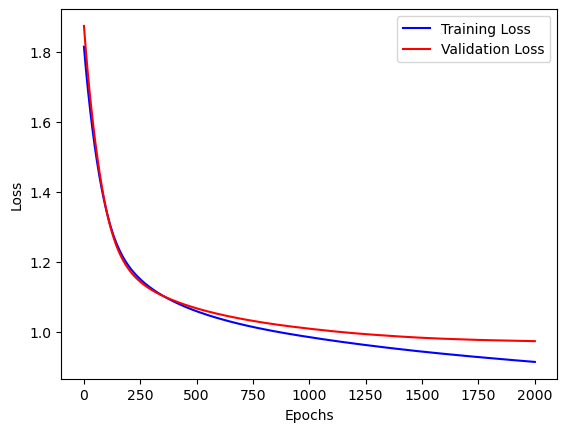

In [213]:
input_size = X.shape[1]
output_size = y.shape[1]

# possible values for activation functions = "tanh", "sigmoid", "relu", "identity", "softmax" 
#                                                                   for regression , for classification
# 
# possible values for optimizer = "sgd", "bgd", "mbgd"


# batch_size is only needed when optimizer is "mbgd"

# Mini-Batch Gradient Descent
# mbgd
# mlp = MLP(input_size=input_size, hidden_layer_sizes=[32, 32], output_size=output_size, \
#                     activation_function=["relu", "relu"], output_activation_function="softmax",\
#                         optimizer="mbgd", loss=CrossEntropyLoss(), learning_rate=0.01)
# mlp.train(X_train, y_train, X_val, y_val, epochs=10000, batch_size=32)

# Stochastic Gradient Descent
# sgd
# mlp = MLP(input_size=input_size, hidden_layer_sizes=[32, 32], output_size=output_size, \
#                     activation_function=["relu", "relu"], output_activation_function="softmax",\
#                         optimizer="sgd", loss=CrossEntropyLoss(), learning_rate=0.01)
# mlp.train(X_train, y_train, X_val, y_val, epochs=1000)

# Batch Gradient Descent
# bgd
mlp = MLP(input_size=input_size, hidden_layer_sizes=[32, 32], output_size=output_size, \
                    activation_function=["relu", "relu"], output_activation_function="softmax",\
                        optimizer="bgd", loss=CrossEntropyLoss(), learning_rate=0.01)
mlp.train(X_train, y_train, X_val, y_val, epochs=2000)

plt.plot(range(1, len(mlp.losses) + 1), mlp.losses, color='b', label='Training Loss')
plt.plot(range(1, len(mlp.val_losses) + 1), mlp.val_losses, color='r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# 2.2 Model Training & Hyperparameter Tuning using W&B
# [10 marks]
# Effective tuning can vastly improve a model’s performance. Integrate Weights
# & Biases (W&B) to log and track your model’s metrics. Using W&B and your
# validation set, experiment with hyperparameters such as learning rate, epochs,
# hidden layer neurons, activation functions, and optimization techniques. You
# have to use W&B for loss tracking during training and to log effects of different
# activation functions and optimizers on model performance.
# 1. Log your scores - loss and accuracy on validation set and train set using
# W&B.
# 2. Report metrics: accuracy, f-1 score, precision, and recall. You are allowed
# to use sklearn metrics for this part.
# 3. You have to report the scores(ordered) for all the combinations of :
# • Activation functions : sigmoid, tanh and ReLU (implemented from
# scratch)
# • Optimizers : SGD, batch gradient descent, and mini-batch gradient
# descent (implemented from scratch).
# 4. Tune your model on various hyperparameters, such as learning rate, epochs,
# and hidden layer neurons.
# • Plot the trend of accuracy scores with change in these hyperparam-
# eters.
# • Report the parameters for the best model that you get (for the various
# values you trained the model on).
# • Report the scores mentioned in 2.2.2 for all values of hyperparameters
# in a table.



# For Regression

loss function -> mean squared error

output_size = 1

In [ ]:
# PATH = './dataset/WineQT.csv'
# df = pd.read_csv(PATH)
# # drop the Id column
# df = df.drop('Id', axis=1)
# df.head()

In [ ]:
# scaler = StandardScaler()
# df_scaled = scaler.fit_transform(df.drop('quality', axis=1))
# df_scaled = pd.DataFrame(df_scaled, columns=df.columns[:-1])

# quality_min = df['quality'].min()
# # print(quality_min)
# df_scaled['quality'] = df['quality'].apply(lambda x: x - quality_min)

In [ ]:
# X = df_scaled.drop(['quality'], axis=1)\
#                         .values

# y = df_scaled[['quality']]\
#         .values
        
# print(X.shape)
# print(y.shape)